## Demo for More Advanced Interferometry Simulation and Custom TDI Combination

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Offset import *
from Triangle.Plot import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import * 

# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

/Users/taijidatacenter/miniconda3/envs/triangle/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Set logging and multiprocessing

run this cell only ONCE

In [2]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [3]:
import multiprocessing
print('number of cpus =', multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# pool = None 

number of cpus = 12


## 1. More advanced simulations

### 1.1 vary noise amplitudes for different MOSAs 
Simulate a secondary-noise-only data, but the noise amplitudes are different for different MOSAs.

Generally, other noises in the ifo.BasicNoise dictionary can also be modified, or replaced by your own noise data, including:

'acc_noise', 'ro_sci_c_noise', 'ro_sci_sb_noise', 'ro_ref_c_noise', 'ro_ref_sb_noise', 'ro_tm_c_noise', 'laser_noise', 'ob_noise', 'clock_noise', 'bl_noise', 'ranging_noise', 'op_sci_local_noise', 'op_sci_distant_noise', 'op_ref_local_noise', 'op_ref_adjacent_noise', 'op_tm_local_noise', 'op_tm_adjacent_noise', 'modulation_noise'

In [4]:
fsample = 10
data_time = 1 * DAY 
ifo_drop_time1 = 100 
ifo_drop_time2 = 100
tdi_drop_time1 = 100
tdi_drop_time2 = 100 
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 31

orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(unit='ffd') 

ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2,
    telemetry_downsample=None, 
    detrend_order=None, 
    acc_noise=True,
    ro_noise=True, 
    laser_noise=False, 
    clock_noise=False, 
    ob_noise=False,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=False, 
    )

# break the ifo.SimulateInterferometer() function into steps so that we can modify the intermediate variables 
ifo.SimulateBasicNoise()

# modify the amplitudes of acceleration noises 
for key in MOSA_labels:
    ifo.BasicNoise['ro_sci_c_noise'][key] *= np.random.uniform(1.5, 2.5)  
    
ifo.SimulateRangeAndClock()
if ifo.gw_flag:
    ifo.SimulateGW()
ifo.SimulateMeasurements()
m = ifo.OutputMeasurements(mode='decomposed')

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=31, delay_order=5)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)
tdi.CalculateBasicTDI(channel='X2', doppler=True)

tdi.measurements.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 868000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generating clock offsets.
INFO:Triangle.Interferom

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X2'])

#### plot the ASD of TDI 
the results are different from the nominal noise level due to the aforementioned modification. 

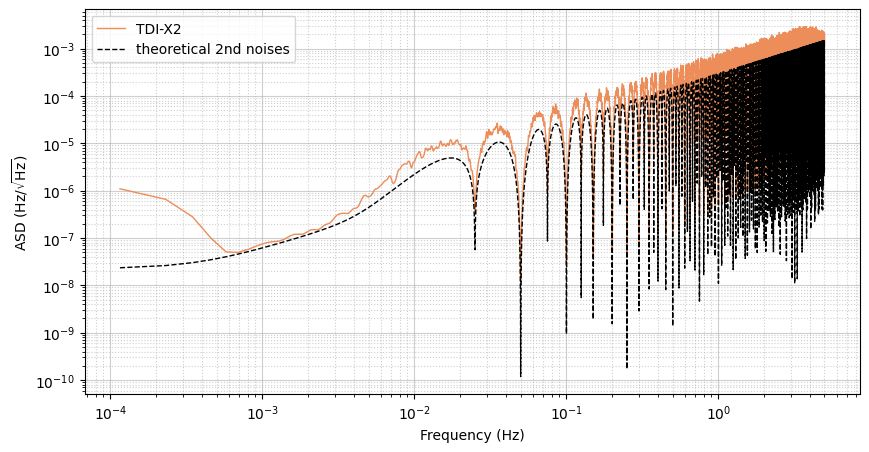

In [5]:
arms = dict()
arm_idx = int(len(m1['ltt']['12']) / 2.)
for k, v in m1['ltt'].items():
    arms[k] = v[arm_idx]

win = 'kaiser'
windict = dict(beta=28)
nbin = 10 # NOTE: calculate average PSD to show the shape more clearly 
drop1 = int(tdi_drop_time1 * fsample) 
drop2 = -int(tdi_drop_time2 * fsample) 

plt.figure(figsize=(10, 5))

f, xf = PSD_window(tdi.measurements['X2'][drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=ORANGE, linewidth=1, label='TDI-X2')

PSD = TDIPSDs()
PSD_X2 = PSD.PSD_X2_unequal(f, arms) 
plt.loglog(f, np.sqrt(PSD_X2) * F_LASER, color='k', linestyle='--', linewidth=1, label = 'theoretical 2nd noises') # theoetidal noise PSD based on the "nominal" noise amplitudes 

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD ' + r'${\rm (Hz/\sqrt{Hz})}$')

plt.legend(loc='upper left')


### 1.2 Glitch injection 
Simulate a glitch-only data. A "LPF legacy" glitch is injected to test-mass 12. 

In [6]:
fsample = 10 
data_time = 1 * DAY 
ifo_drop_time1 = 100 
ifo_drop_time2 = 100
tdi_drop_time1 = 100
tdi_drop_time2 = 100 
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 31

orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(unit='ffd') 

ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2,
    telemetry_downsample=None, 
    detrend_order=None, 
    acc_noise=True, # create the interface of test-mass glitch 
    ro_noise=False, 
    laser_noise=False, 
    clock_noise=False, 
    ob_noise=False,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=False, 
    )

ifo.SimulateBasicNoise()
ifo.SimulateRangeAndClock()

# add glitch to the acceleration noise 
glitch = Glitch(fsample=ifo.fsample)
glitch_simulation_time = ifo.proper_time['1'] # generate glitch according to the proper time of spacecraft 1 
glitch_injection_time = 30000. # set injection time 
short_glitch_acc = glitch.LPF_legacy_glitch_model(t=glitch_simulation_time, t0=glitch_injection_time, **glitch.short_glitch_kwargs) # generate glitch in the acceleration unit 
short_glitch_ffd = glitch.acc2ffd(short_glitch_acc) # convert to the fractional frequency difference unit 
for key in MOSA_labels: 
    ifo.BasicNoise['acc_noise'][key] *= 0. # clean acceleration noises 
ifo.BasicNoise['acc_noise']['12'] = short_glitch_ffd # inject glitch 

if ifo.gw_flag:
    ifo.SimulateGW()
ifo.SimulateMeasurements()
m = ifo.OutputMeasurements(mode='decomposed')

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=31, delay_order=5)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)
tdi.CalculateBasicTDI(channel='X2', doppler=True)

tdi.measurements.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 868000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generating clock offsets.
INFO:Triangle.Interferometer:Clock offsets generated.
INFO:Triangle.Interferometer:Generating unlocked sources.
INFO:Triangle.Interferometer:unlocked sources generated.
INFO:Triangle.Interferometer:Generating locked sources.
INFO:Triangle.Interferome

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X2'])

#### visualize glitch in the TDI channel 

Text(0, 0.5, 'Glitch in TDI X2')

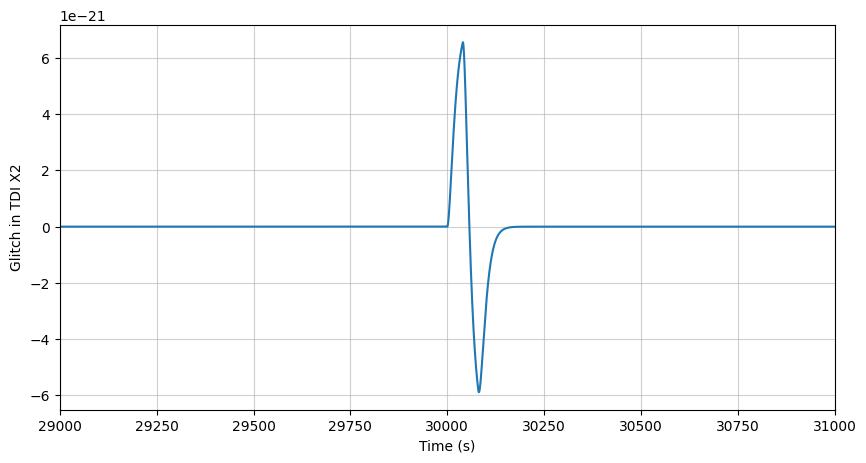

In [7]:
drop1 = int(tdi_drop_time1 * fsample)
drop2 = -int(tdi_drop_time2 * fsample)

plt.figure(figsize=(10, 5))

plt.plot(tdi.measurements['time']['1'][drop1:drop2], tdi.measurements['X2'][drop1:drop2] / F_LASER) # convert to fractional frequency difference unit 

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlim(glitch_injection_time - 1000, glitch_injection_time+1000)

plt.xlabel('Time (s)')
plt.ylabel('Glitch in TDI X2')

## 2. Custom TDI combinations 
Custom TDI combinations can be constructed in 4 ways: 
- by channel name, only valid for "X_1", "X_2", "alpha_1", "alpha_2"; 
- by a faster implementation of the Michelson channels;
- by strings specifying the synthesized optical paths, e.g. ['121313121', '131212131'] stands for the "X_2" channel, with the 1st string being the path with plus sign, and the 2nd being the path with minus sign;
- by strings specifying the $\boldsymbol{\rm P}_{ij}$ operators so that ${\rm TDI} = \sum_{ij} \boldsymbol{\rm P}_{ij} \eta_{ij}$. This method is the slowest, but can be applied to the widest range of TDI channels. e.g. For the 2nd-generation Michelson X channel, the $P_{ij}$ operators are: 
\begin{align}
    \textbf{P}_{12} &= -1 + \textbf{D}_{131} + \textbf{D}_{13121} - \textbf{D}_{1213131}, \nonumber \\ 
    \textbf{P}_{23} &= 0, \nonumber \\ 
    \textbf{P}_{31} &= \textbf{D}_{13} - \textbf{D}_{1213} - \textbf{D}_{121313} + \textbf{D}_{13121213}, \nonumber \\ 
    \textbf{P}_{21} &= -\textbf{D}_{12} + \textbf{D}_{1312} + \textbf{D}_{131212} - \textbf{D}_{12131312}, \nonumber \\ 
    \textbf{P}_{32} &= 0, \nonumber \\ 
    \textbf{P}_{13} &= 1 - \textbf{D}_{121} - \textbf{D}_{12131} + \textbf{D}_{1312121}.  \nonumber
\end{align}
which can be specified by the following strings: 

In [8]:
# "ij" represents the delay operator D_{ij}, while "-ij" stands for the corresponding "advance" operator A_{ij}
X2_string = {
    "12": [(-1., []), (1., ["13", "31"]), (1., ["13", "31", "12", "21"]), (-1., ["12", "21", "13", "31", "13", "31"])], 
    "23": [], 
    "31": [(1., ["13"]), (-1., ["12", "21", "13"]), (-1., ["12", "21", "13", "31", "13"]), (1., ["13", "31", "12", "21", "12", "21", "13"])], 
    "21": [(-1., ["12"]), (1., ["13", "31", "12"]), (1., ["13", "31", "12", "21", "12"]), (-1., ["12", "21", "13", "31", "13", "31", "12"])], 
    "32": [], 
    "13": [(1., []), (-1., ["12", "21"]), (-1., ["12", "21", "13", "31"]), (1., ["13", "31", "12", "21", "12", "21"])], 
}

#### simulate interferometer data 

In [9]:
fsample = 10
data_time = 1 * DAY 
ifo_drop_time1 = 100 # data at the beginning and end may be invalid (due to interpolation) and should be removed. 
ifo_drop_time2 = 100
tdi_drop_time1 = 100
tdi_drop_time2 = 100 
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 31

orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) # here we start from the 10th day of orbit 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) # no clock drifts
noise = InstrumentalPSDs(unit='ffd') 

ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2,
    telemetry_downsample=None, 
    detrend_order=None, 
    acc_noise=True,
    ro_noise=True, 
    laser_noise=True, 
    clock_noise=False, 
    ob_noise=False,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=True, 
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 
m1.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 868000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:	laser_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generati

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

#### calculate X2 channel in 4 ways and compare

In [10]:
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=31, delay_order=5)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)

# 1)
tdi.CalculateBasicTDI(channel='X2', doppler=True)
X2_method1 = tdi.measurements['X2'].copy()

# 2)
tdi.FastMichelson(doppler=True, channel='X') # channel can be 'X', 'XYZ' or 'AET'
X2_method2 = tdi.measurements['X2'].copy()

# 3) 
tdi.CalculateBasicTDI(channel=['121313121', '131212131'], doppler=True, channel_name='X2')
X2_method3 = tdi.measurements['X2'].copy()

# 4) 
X2_method4 = tdi.CalculateTDIFromPStrings(X2_string, doppler=True)
X2_method4 *= -1. # the P operators shown above are different from the other 3 methods by a minus sign. 

INFO:Triangle.TDI:TDI channel X2 calculated.
INFO:Triangle.TDI:TDI channel X2 calculated.


#### illustrate the consistency among methods 

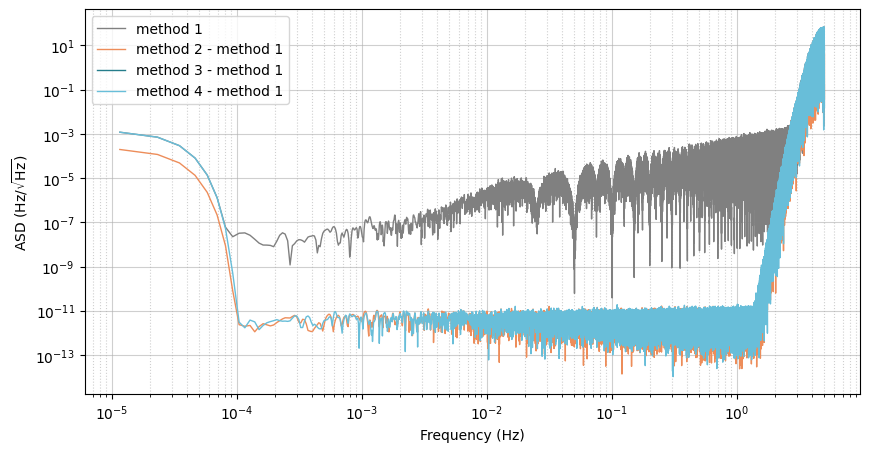

In [11]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 1
drop1 = int(tdi_drop_time1 * fsample) 
drop2 = -int(tdi_drop_time2 * fsample) 

plt.figure(figsize=(10, 5))

f, xf = PSD_window(X2_method1[drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color="grey", linewidth=1, label='method 1')

f, xf = PSD_window((X2_method2 - X2_method1)[drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=ORANGE, linewidth=1, label='method 2 - method 1')

f, xf = PSD_window((X2_method3 - X2_method1)[drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=GREEN1, linewidth=1, label='method 3 - method 1') # equal to 0 hence not shown in the figure 

f, xf = PSD_window((X2_method4 - X2_method1)[drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict) 
plt.loglog(f, np.sqrt(xf), color=BLUE, linewidth=1, label='method 4 - method 1') 

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD ' + r'${\rm (Hz/\sqrt{Hz})}$')

plt.legend(loc='upper left')


## 3. Simulate TDI processing in the presence of clock drifts
- simulate the total interferometry data (not detrended)
- include clock dirfts 
- include sideband modulation noise 
- ranging and synchronization processing using a simple implementation of the "TDI without synchronization" algorithm [PhysRevD.105.122008]

### 3.1 simulate interferometry data 

In [12]:
fsample = 10
data_time = 1 * DAY 
ifo_drop_time1 = 100 # data at the beginning and end may be invalid (due to interpolation) and should be removed. 
ifo_drop_time2 = 100
tdi_drop_time1 = 100
tdi_drop_time2 = 100 
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 31

In [13]:
orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) # here we start from the 10th day of orbit 
offset = OffsetFunctions(laser_flag=False, clock_flag=True) # clock drifts set 
noise = InstrumentalPSDs(unit='ffd') 

In [14]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ClockTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2,
    telemetry_downsample=None, 
    detrend_order=None, 
    acc_noise=True,
    ro_noise=True, 
    laser_noise=True, 
    clock_noise=True, 
    ob_noise=True,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=True, # simulate pseudo ranging with noise 
    modulation_noise=True,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=True, 
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='total') # the raw data is neither detrended nor synchronized 
ifo.clean()

m.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 868000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ClockTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:	laser_noise
INFO:Triangle.Interferometer:	ob_noise
INFO:Triangle.Interferometer:	clock_noise
INFO:Triangle.Interferometer:	ranging_noise
INFO:Triangle.Interferometer:	modulation_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferomete

dict_keys(['sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'mpr', 'ppr', 'fsample', 'time'])

#### plot total interferometry data 

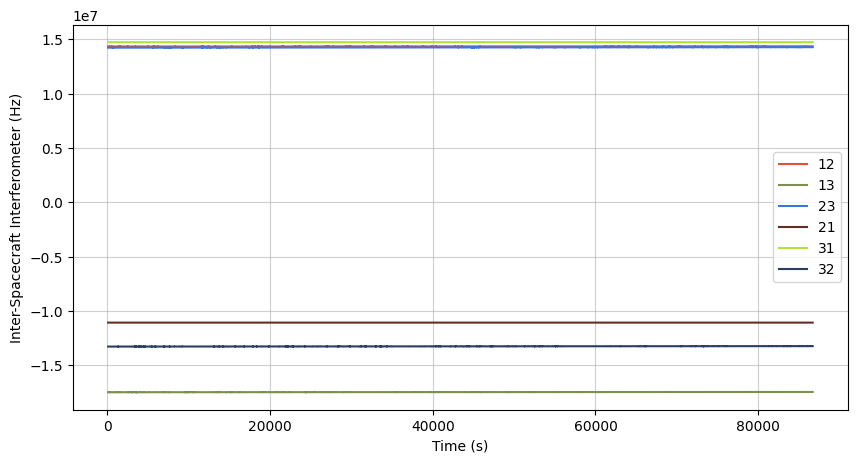

In [15]:
plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    plt.plot(m['time'][key[0]], m['sci_c'][key], color=MOSA_colors[key], label=key)

plt.grid(which='major', alpha=0.6)
plt.xlabel('Time (s)')
plt.ylabel('Inter-Spacecraft Interferometer (Hz)')

plt.legend()

#### plot ranges 
measured pseudo ranges = clock time of receiving laser - clock time of sending laser. This is what we actually measure with pseudo random noise codes (assuming no ambiguity and bias), and what we will used in the next step. 


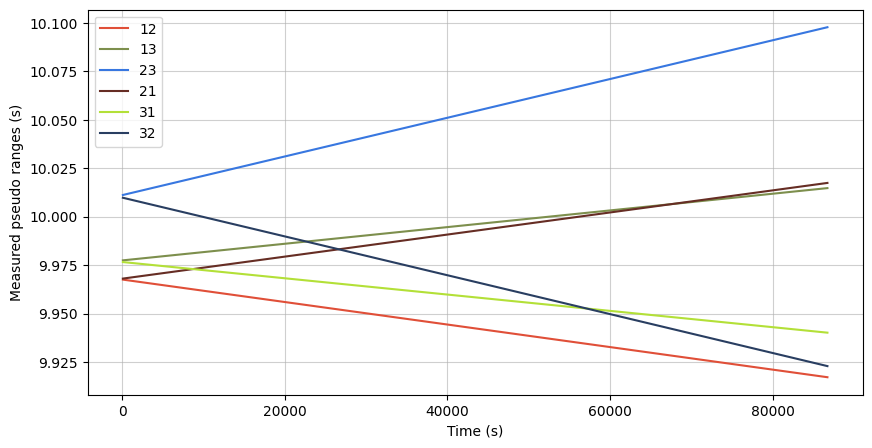

In [16]:
plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    plt.plot(m['time'][key[0]], m['mpr'][key], color=MOSA_colors[key], label=key)

plt.grid(which='major', alpha=0.6)
plt.xlabel('Time (s)')
plt.ylabel('Measured pseudo ranges (s)')

plt.legend()

### 3.2 ranging processing 
combine PRN and sideband to get high-precision inter-spacecraft ranges that can be used in TDI, high-precision dopplers are also calculated.

In [17]:
m1 = RangingProcessing(m, modulation_correction=True, doppler=True)
m1.keys()

dict_keys(['sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'mpr', 'ppr', 'fsample', 'time', 'dpl'])

#### compare the ranges before / after processing 

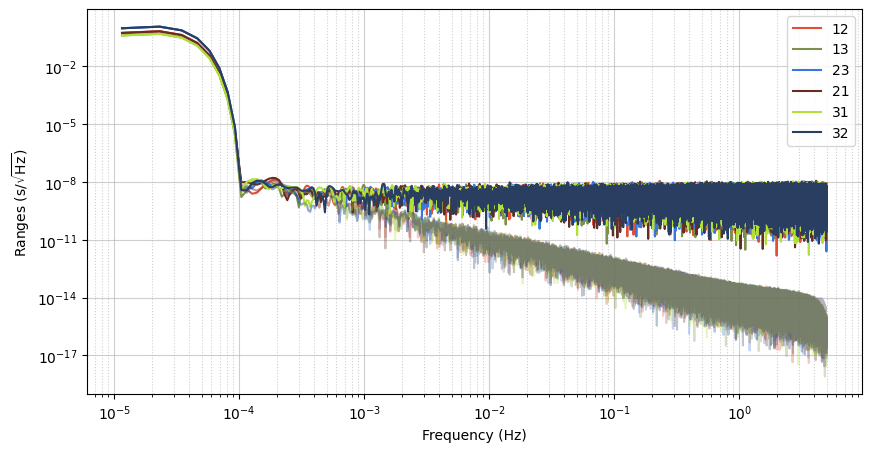

In [18]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 1

plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    f, xf = PSD_window(m['mpr'][key], m['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
    plt.loglog(f, np.sqrt(xf), color=MOSA_colors[key], label=key)
    
    f, xf = PSD_window(m1['mpr'][key], m1['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
    plt.loglog(f, np.sqrt(xf), color=MOSA_colors[key], alpha=0.3)

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Ranges ' + r'${\rm (s/\sqrt{Hz})}$')

plt.legend()

### 3.3 TDI processing 
In this TDI scheme, the clock deviations (both drifts and jitters) are dealt with during the combination of TDI channels, therefore there is no more clock noise reduction step after TDI. 

2 key differences from the traditional TDI scheme: 
- use the total interferometry data instead of the detrended ones. 
- use the PRN ranges instead of the light travel times 

Note that the time frame of the resulting TDI data is the clock time of spacecraft 1 (for X2 channel), and further synchronizing to TCB is still required. 

In [19]:
tdi = TDI(measurements=m1, delays=m1['mpr'], fsample=m1['fsample'], order=31, delay_order=5)
tdi.CalculateXi(pool=pool, doppler=True)
tdi.CalculateEta(doppler=True)
tdi.CalculateBasicTDI(channel='X2', doppler=True)
tdi.measurements.keys()

INFO:Triangle.TDI:TDI channel X2 calculated.


dict_keys(['sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'mpr', 'ppr', 'fsample', 'time', 'dpl', 'xi', 'eta', 'X2'])

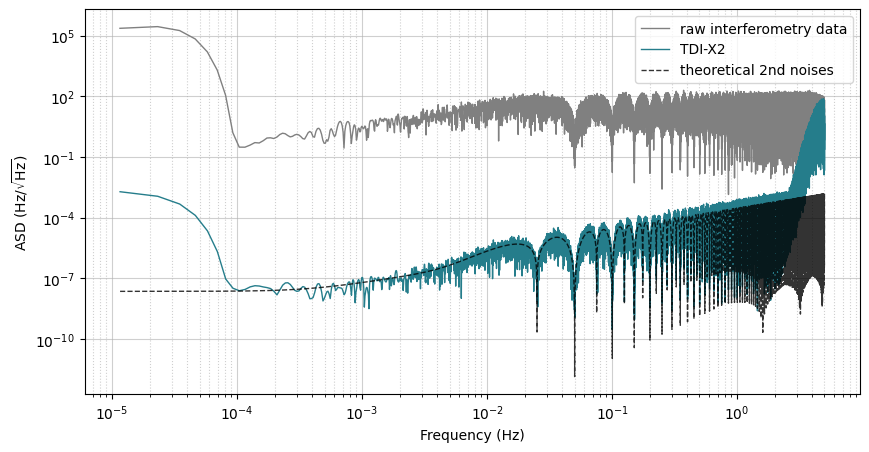

In [20]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 1
drop1 = int(tdi_drop_time1 * fsample)
drop2 = -int(tdi_drop_time2 * fsample)

plt.figure(figsize=(10, 5))

f, xf = PSD_window(m1['sci_c']["12"], m1['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color="grey", label='raw interferometry data', linewidth=1)

f, xf = PSD_window(tdi.measurements['X2'][drop1:drop2], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=GREEN1, label='TDI-X2', linewidth=1)

PSD = TDIPSDs()
PSD_X2 = PSD.PSD_X2_unequal(f, arms)
plt.loglog(f, np.sqrt(PSD_X2) * F_LASER, color='k', linestyle='--', alpha=0.8, linewidth=1, label = 'theoretical 2nd noises')

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD ' + r'${\rm (Hz/\sqrt{Hz})}$')

plt.legend()
